# Feature Selection

This notebook explores the features extracted when running feature selection on data that has been divided based on different categorical demographic features (eg. age, gender, religion, language, etc.)

The goal of this analysis is to see if there are features that may be specific to one group of individuals

### Feature Selection (full dataset):

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
import sys
import pandas as pd

# This dataset has already filtered out all columns where zeros represent more than 70% of rows
df_full = pd.read_csv('../data/exp/pneumonia-t3/first24hours.csv', header=0)
print("Orig columns " + str(len(df_full.columns)))
print(df_full["los"].describe())
print(df_full["los"].median())

print("Died = " + str(len(df_full[df_full["status"] == 1])))
print("Alive = " + str(len(df_full[df_full["status"] == 0])))
print("LOS of Died = ")
#print(df_full[df_full["status"] == 1].describe())
print("LOS of Alive")
#print(df_full[df_full["status"] == 0].describe())

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

# Remove outliers
df = df[df['los'] <= 100]

status = df.pop('status')
los = df.pop('los')

# One hot encode or delete the demographic columns
# 
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    df = df.join(one_hot)

# Perform another round to filter out low-prevalence columns. 
# This is needed otherwise feature selection will pick out columns that may only have one or two patients
print("Before filtering low-prevalence " + str(len(df.columns)))
df = df.loc[:, (df==0).mean() < .9]

print("After filtering low-prevalence " + str(len(df.columns)))
    
X = df.values
y = los


Orig columns 2341
count    4507.000000
mean       11.869538
std        10.985354
min        -0.188000
25%         5.167000
50%         8.859000
75%        14.862000
max       206.426000
Name: los, dtype: float64
8.859
Died = 744
Alive = 3763
LOS of Died = 
LOS of Alive
Before filtering low-prevalence 328
After filtering low-prevalence 237


In [20]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from math import sqrt

# NORMALIZE THE DATASET
stats = df.describe()
stats = stats.transpose()

def norm(x):
  return (x - stats['mean']) / stats['std']
normed_df = norm(df)

print("Num columns before feature selection: " + str(len(normed_df.columns)))

# RUN FEATURE SELECTION BASED ON SGD LINEAR REGRESSION
clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
sfm = SelectFromModel(clf, threshold=0.26) #0.19 = 72 features -> pretty good
sfm.fit(normed_df, los)
feature_idx = sfm.get_support()
transformed_df = normed_df.loc[:,feature_idx]
print("Num columns after feature selection: " + str(len(transformed_df.columns)))
print(transformed_df.columns)


Num columns before feature selection: 237
Num columns after feature selection: 42
Index(['age', 'Bands-trend', 'PTT-trend', 'Potassium', 'Calcium, Total',
       'Lactate', 'Oxygen Saturation', 'Creatine Kinase, MB Isoenzyme-trend',
       'PEEP', 'Albumin', 'Free Calcium', 'Cortisol', 'MICROK10', 'CHLO15L',
       'SENN187', 'NACLFLUSH', 'OXYC5', 'NS250', 'PROP100IG', 'MORP2I',
       'PNEU25I', 'HEPA5I', 'LEV250', 'BAG50', 'LORA2I', 'ZITHR250', 'NS100',
       'DOCU100L', 'Heart Rate', 'Systolic', 'O2 Flow.1', 'O2 Flow-trend.1',
       'Respiratory Rate', 'Temperature.1', 'O2', 'O2-trend',
       'insurance_Medicare', 'insurance_Private', 'language_0',
       'language_ENGL', 'religion_CATHOLIC',
       'ethnicity_BLACK/AFRICAN AMERICAN'],
      dtype='object')


Training LOS: 6.470871860175729


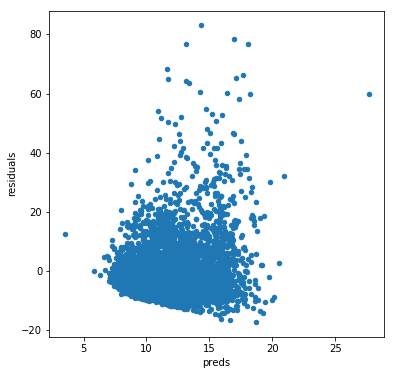

In [21]:
from sklearn.linear_model import ElasticNet
import matplotlib
import matplotlib.pyplot as plt

elastic = ElasticNet(l1_ratio=0.35, max_iter=10000)
elastic.fit(normed_df, los)

y_train_preds = elastic.predict(normed_df)
training_error = mean_absolute_error(los, y_train_preds)
print("Training LOS: " + str(training_error))

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":elastic.predict(normed_df), "true":los})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")


Elastic Net picked 53 variables and eliminated the other 184 variables
Index(['Heart Rate', 'Systolic', 'O2', 'age', 'NS100', 'O2 Flow-trend.1',
       'PEEP', 'insurance_Medicare', 'PROP100IG', 'O2 Flow.1',
       'Respiratory Rate', 'Tidal Volume', 'Neutrophils', 'IPRA2H', 'LEV250',
       'Diastolic', 'NS250', 'KCLBASE2', 'Albumin', 'KCL20PM', 'ZITHR250',
       'Hematocrit', 'LORA2I', 'HEPA5I', 'Red Blood Cells', 'CALG1I',
       'language_0', 'CHLO15L', 'Free Calcium', 'Amylase', 'SENN187',
       'Fibrinogen, Functional', 'ALBU3H', 'Creatinine, Urine',
       'Hematocrit, Calculated', 'Oxygen Saturation', 'MIDA50I', 'CEFX1F',
       'MCHC-trend', 'Bands-trend', 'Osmolality, Urine', 'language_ENGL',
       'PNEU25I', 'Lipase', 'Heart Rate-trend', 'Lactate', 'Hemoglobin',
       'Alkaline Phosphatase', 'Platelet Count', 'Potassium, Urine',
       'NACLFLUSH', 'MORP2I', 'O2-trend'],
      dtype='object')


Text(0.5,1,'Coefficients in the Elastic Net Model')

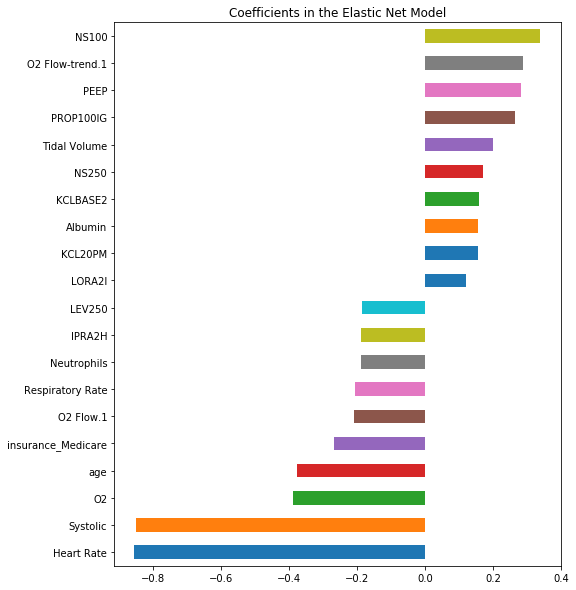

In [25]:

coef = pd.Series(elastic.coef_, index = normed_df.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


features = coef.abs().sort_values(ascending=False).head(64)
features = features[coef != 0]
print(features.index)

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

In [3]:
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
skb = SelectKBest(f_regression, k=64)
X_new = skb.fit(X, y)
feature_idx = skb.get_support()
transformed_df = df.columns[feature_idx]
print("Num columns before feature selection: " + str(len(df.columns)))
print("Num columns after feature selection: " + str(len(transformed_df)))
transformed_df


Num columns before feature selection: 237
Num columns after feature selection: 64


Index(['age', 'Hematocrit', 'Hemoglobin', 'MCHC-trend', 'MCV-trend',
       'Neutrophils', 'Platelet Count', 'Potassium', 'Red Blood Cells',
       'Lactate', 'Oxygen Saturation', 'Temperature', 'Oxygen', 'PEEP',
       'Tidal Volume', 'Lipase', 'Albumin', 'Free Calcium',
       'Sodium, Whole Blood', 'NTproBNP', 'Hematocrit, Calculated',
       'Chloride, Whole Blood', 'Fibrinogen, Functional', 'Amylase', 'FENT2I',
       'CHLO15L', 'PRED20', 'CEFX1F', 'KCL20PM', 'SENN187', 'MIDA50I',
       'DOCU100', 'NACLFLUSH', 'ALBU3H', 'IPRA2H', 'ASA81', 'NS250',
       'PROP100IG', 'MORP2I', 'PNEU25I', 'PANT40I', 'HEPA5I', 'LEV250',
       'ISONACL', 'LORA2I', 'LR1000', 'KCLBASE2', 'METO25', 'MAGS1I',
       'ZITHR250', 'NS100', 'D5W250', 'CALG1I', 'Heart Rate', 'Diastolic',
       'Systolic', 'O2 Flow.1', 'O2 Flow-trend.1', 'Respiratory Rate', 'O2',
       'insurance_Medicare', 'insurance_Private', 'language_0',
       'language_ENGL'],
      dtype='object')

In [46]:
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from statsmodels.stats.multitest import multipletests

f_vals, p_vals = f_regression(X, y)
features = df.columns

_, q_vals, _, _ = multipletests(p_vals, method="bonferroni")
features = df.columns
output = [a for a in zip(features, f_vals, p_vals, q_vals)]

output.sort(key=lambda pair: pair[1], reverse=True)

i = 0
while i < len(output):
    print(str(output[i][0]) + "," + str(output[i][1]) + "," + str(output[i][2]) + "," + str(output[i][3]))
    if output[i][3] > 0.01:
        break
    i += 1


Systolic,294.8190293708962,4.655487406200813e-64,1.1033505152695927e-61
Heart Rate,214.88126334728332,1.4511800807849014e-47,3.439296791460216e-45
Diastolic,117.32973872559009,5.2175657712105116e-27,1.2365630877768913e-24
O2,109.17523020639781,2.8824903752890295e-25,6.831502189435e-23
Neutrophils,74.15281921397457,9.856728767092773e-18,2.3360447178009874e-15
IPRA2H,72.18735797858736,2.6260116825915575e-17,6.223647687741991e-15
age,65.62433224841786,6.962973653514395e-16,1.6502247558829117e-13
O2 Flow.1,60.895291454900395,7.430386640915351e-15,1.7610016338969382e-12
PEEP,59.74121586094897,1.3251868245130259e-14,3.1406927740958714e-12
insurance_Medicare,59.29799216045033,1.655055730159203e-14,3.9224820804773106e-12
NS100,57.36622654189527,4.363151831491988e-14,1.034066984063601e-11
Tidal Volume,56.64743147189803,6.259642563811462e-14,1.4835352876233165e-11
PROP100IG,55.06950588795002,1.3830965285268269e-13,3.2779387726085794e-11
ALBU3H,54.41469704387184,1.9222703003128519e-13,4.555780611

In [3]:
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
# Higher values indicate more dependency
vals = mutual_info_regression(X, y)
features = df.columns
output = [a for a in zip(features, vals)]
output.sort(key=lambda pair: pair[1], reverse=True)

i = 0
while i < 30:
    print(str(output[i][0]) + "," + str(output[i][1]))
    #print(str(output[i][0]))
    i += 1

    

Respiratory Rate-trend,0.0717450527948702
O2 Flow.1,0.07155889955780292
Diastolic,0.06311960527893934
Respiratory Rate,0.06087676884494364
Systolic,0.05329235257786191
O2-trend,0.048644475619019634
MCHC-trend,0.045596574727086114
pH-trend,0.04531704604274056
Diastolic-trend,0.044436463819963024
Systolic-trend,0.043131678336240764
O2 Flow-trend.1,0.042609224787026445
Heart Rate-trend,0.041564748590813494
Urea Nitrogen-trend,0.04117892693248315
Creatinine-trend,0.039274741067944596
Oxygen,0.03889932585666056
White Blood Cells-trend,0.038776714413117475
RDW-trend,0.03789084400012843
pH,0.03685092679564139
Heart Rate,0.036184188865125755
Phosphate-trend,0.03495656265320779
Alkaline Phosphatase,0.03259947294690013
Sodium-trend,0.03195840326424104
Potassium-trend,0.031156655528721267
Hematocrit-trend,0.030954746243966547
Hemoglobin-trend,0.030720452542735366
Magnesium-trend,0.03025024045345681
Calculated Total CO2-trend,0.0301686421506262
PEEP,0.030135632820289526
Bicarbonate-trend,0.0287862

### Extract features by different demographic features:
- Age
- Medicaid
- Ethnicity
- Gender

In [14]:
############
# AGE 
# Three categories: elderly (>= 65) vs adult (18-65) vs children (0-18)
############

# 
# By f_regression (feature by feature)
#

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, SelectFdr
import sys
import pandas as pd
from statsmodels.stats.multitest import multipletests

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

status = df.pop('status')
los = df.pop('los')

# Remove the demographic columns
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    # df = df.join(one_hot)

df_elderly = df[df['age'] >= 65]
los_elderly = los[df['age'] >= 65]
df_adult = df[(df['age'] < 65) & (df['age'] >= 18)]
los_adult = los[(df['age'] < 65) & (df['age'] >= 18)]
df_child = df[df['age'] < 18]
los_child = los[df['age'] < 18]

def calc_f_regression(title, X, y):
    print("Analyzing: " + title + " (" + str(len(X)) + ")")
    f_vals, p_vals = f_regression(X, y)
    _, q_vals, _, _ = multipletests(p_vals, method="bonferroni")
    features = df.columns
    output = [a for a in zip(features, f_vals, p_vals, q_vals)]
    output.sort(key=lambda pair: pair[1], reverse=True)

    i = 0
    while i < 30:
        print("   Feature: " + str(output[i][0]) + " @ " + str(output[i][1]) + " with pval " + str(output[i][2]) + " with qval " + str(output[i][3]))
        i += 1

X = df_elderly.values
y = los_elderly
calc_f_regression("Elderly", X, y)

X = df_adult.values
y = los_adult
calc_f_regression("Adult", X, y)

X = df_child.values
y = los_child
calc_f_regression("Child", X, y)

Analyzing: Elderly (2580)
   Feature: Systolic @ 200.06224662730486 with pval 8.427029237674139e-44 with qval 1.870800490763659e-41
   Feature: Diastolic @ 189.86715424464157 with pval 9.869742493669488e-42 with qval 2.1910828335946262e-39
   Feature: Heart Rate @ 165.22919597780364 with pval 1.065593627355499e-36 with qval 2.3656178527292077e-34
   Feature: O2 @ 79.4153098267913 with pval 9.304600362532518e-19 with qval 2.065621280482219e-16
   Feature: age @ 61.65115123734709 with pval 5.963144062003561e-15 with qval 1.3238179817647904e-12
   Feature: PROP100IG @ 50.627707030402476 with pval 1.4408901543605884e-12 with qval 3.1987761426805063e-10
   Feature: Tidal Volume @ 48.73204603638075 with pval 3.718021589504446e-12 with qval 8.254007928699871e-10
   Feature: NS100 @ 43.23348564466951 with pval 5.860063448133822e-11 with qval 1.3009340854857085e-08
   Feature: MAGS1I @ 37.43494939591716 with pval 1.089037405832142e-09 with qval 2.417663040947355e-07
   Feature: IPRA2H @ 36.0801

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/stats/multitest.py:153: RuntimeWarning: invalid value encountered in less_eq

In [12]:
############
# GENDER 
# Three categories: male ("M") vs female ("F")
############

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
import sys
import pandas as pd

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

status = df.pop('status')
los = df.pop('los')

# Drop the demographic columns
cols_to_one_hot = ['insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)

df_male = df[df['gender'] == "M"]
los_male = los[df['gender'] == "M"]
df_male.pop('gender')

df_female = df[df['gender'] == "F"]
los_female = los[df['gender'] == "F"]
df_female.pop('gender')

X = df_male.values
y = los_male
calc_f_regression("Male", X, y)

X = df_female.values
y = los_female
calc_f_regression("Female", X, y)


Analyzing: Male (2452)
   Feature: Diastolic-trend @ 135.7112103418164 with pval 1.4523958596506711e-30
   Feature: NEUT @ 110.46372085401543 with pval 2.6555500590995594e-25
   Feature: Temperature-trend.1 @ 62.051184362713485 with pval 4.986319632883497e-15
   Feature: ALBU17H @ 46.08650938625503 with pval 1.4145072235498556e-11
   Feature: Monocytes-trend @ 41.58122876623541 with pval 1.357516184986593e-10
   Feature: Heart Rate-trend @ 40.16831076073128 with pval 2.764244117656148e-10
   Feature: NACLFLUSH @ 39.72919165757172 with pval 3.448592978693821e-10
   Feature: PEEP @ 37.44303120644116 with pval 1.0925820234473925e-09
   Feature: Systolic-trend @ 37.26324394501631 with pval 1.1964317372107938e-09
   Feature: Oxygen-trend @ 36.648747645373554 with pval 1.6320191277719185e-09
   Feature: age @ 33.32351816684909 with pval 8.78914144082984e-09
   Feature: MAG2PM @ 30.654999455914524 with pval 3.410692500271311e-08
   Feature: PANT40 @ 29.286385811018498 with pval 6.849635265044

In [20]:
############
# INSURANCE 
############

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
import sys
import pandas as pd

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

status = df.pop('status')
los = df.pop('los')

# Drop the demographic columns
cols_to_one_hot = ['gender', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)

col_of_interest = 'insurance'
for val in df[col_of_interest].unique():
    df_val = df[df[col_of_interest] == val]
    los_val = los[df[col_of_interest] == val]
    df_val.pop(col_of_interest)

    X = df_val.values
    y = los_val
    calc_f_regression(val, X, y)



Analyzing: Private (1156)
   Feature: Diastolic-trend @ 84.90073074318309 with pval 1.4405451365316691e-19
   Feature: NEUT @ 73.41349175940923 with pval 3.323837327509262e-17
   Feature: Hemoglobin @ 34.52216268395245 with pval 5.5079017831104895e-09
   Feature: Red Blood Cells @ 28.17761596053825 with pval 1.3265705284605417e-07
   Feature: O2 Flow-trend.1 @ 27.72771869566012 with pval 1.664609066269299e-07
   Feature: RDW-trend @ 26.857843135502463 with pval 2.5832596047500927e-07
   Feature: VANC1F @ 25.05127434532032 with pval 6.451062099041649e-07
   Feature: Glucose-trend @ 24.63793064802483 with pval 7.957705669827802e-07
   Feature: Hematocrit @ 23.641422284575466 with pval 1.3209980228976819e-06
   Feature: Hematocrit-trend @ 23.590662980625297 with pval 1.3555880128210897e-06
   Feature: NACLFLUSH @ 21.154908279906902 with pval 4.703770355874902e-06
   Feature: PANT40I @ 20.798748477076835 with pval 5.645956371010216e-06
   Feature: ALBU17H @ 20.75066731595167 with pval 5.78

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Ttest_indResult(statistic=-5.423044725198354, pvalue=9.958208303327191e-08)


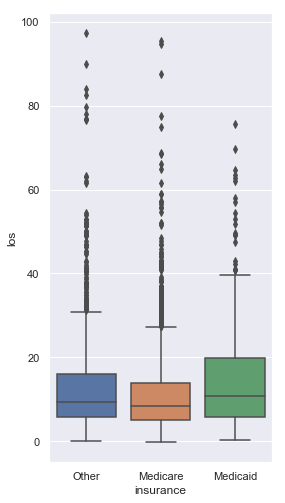

In [28]:
############
# INSURANCE BOXPLOTS
############

import seaborn as sns
import pandas as pd
from scipy import stats

sns.set(rc={'figure.figsize':(4,8.27)})

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

# Remove outliers
df = df[df['los'] <= 100]

df.loc[df["insurance"] == "Medicaid", 'insurance'] = "Medicaid"
df.loc[df["insurance"] == "Private", 'insurance'] = "Other"
df.loc[df["insurance"] == "Medicare", 'insurance'] = "Medicare"
df.loc[df["insurance"] == "Government", 'insurance'] = "Other"
df.loc[df["insurance"] == "Self Pay", 'insurance'] = "Other"
ax = sns.boxplot(x="insurance", y="los", data=df)
alive = df[df["insurance"] == "Medicare"]
dead = df[df["insurance"] == "Medicaid"]
print(stats.ttest_ind(alive["los"], dead["los"], equal_var = False))


Ttest_indResult(statistic=-0.047728051252038495, pvalue=0.9619419107063983)


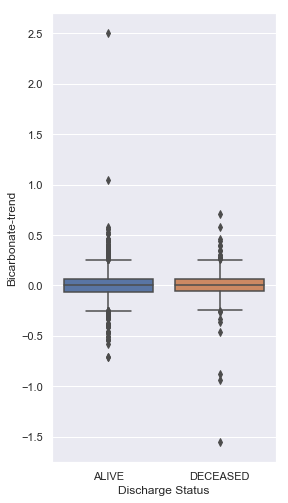

In [76]:
############
# BOXPLOTS
############

import seaborn as sns
import pandas as pd
from scipy import stats

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)
# df = df[df["Anion Gap"] > 0]
df["Discharge Status"] = df['status'].map({0: "ALIVE", 1: "DECEASED"})
ax = sns.boxplot(x="Discharge Status", y="Bicarbonate-trend", data=df)
alive = df[df["status"] == 0]
dead = df[df["status"] == 1]
print(stats.ttest_ind(alive["Bicarbonate-trend"], dead["Bicarbonate-trend"], equal_var = False))



---

### Explore feature selection on the patient outcomes (alive vs expired)
Because patient outcomes is a categorical feature, we will use a random forest classifier instead


In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Consider imputing the data with values other than zero
df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)

df.pop('los')
status = df.pop('status')

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(df.values, status)

output = [a for a in zip(df.columns, clf.feature_importances_)]
output.sort(key=lambda pair: pair[1], reverse=True)

i = 0
while i < 30:
    print(str(output[i][0]) + "," + str(output[i][1]))
    i += 1


age,0.01725622901397037
Urea Nitrogen,0.015501782148553727
Platelet Count,0.014677345770448885
Bicarbonate-trend,0.014470115740924761
Lactate Dehydrogenase (LD),0.01434109577730063
Anion Gap,0.013609254916032237
Systolic,0.013083184284478315
Phosphate,0.012325595876926861
White Blood Cells-trend,0.012249305403098472
RDW,0.012209054904351473
Respiratory Rate-trend,0.011919273659788595
Diastolic,0.011512500139611827
Lactate,0.011455641011552957
O2-trend,0.011239987990436443
White Blood Cells,0.01122557856442702
MCV-trend,0.010924839610155368
Anion Gap-trend,0.01067699118504217
Heart Rate,0.01066551589189517
MCHC-trend,0.010621889347755318
Neutrophils,0.010516643833633215
Heart Rate-trend,0.01020713583340102
Platelet Count-trend,0.009977912298293725
Bicarbonate,0.009836861192150905
Lymphocytes,0.009775762409445584
Hematocrit-trend,0.009593518994937126
Calcium, Total,0.009488152041567725
Creatinine,0.009413717194439406
MCH-trend,0.009406597435050847
Potassium,0.009273796693158653
Glucose-t

### PCA 
Based on the features selected, generate PCA and explore variance for different populations

In [61]:
### Try PCA
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

# Consider imputing the data with values other than zero
raw_dataset = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0)
df = raw_dataset.copy()

#df = df.loc[:, (df==0).mean() < .7]
#df.fillna(0, inplace=True)
#df = df.replace([np.inf, -np.inf], 0)

# Remove outliers
df = df[df['los'] <= 100]

# Remove rows where the chartevents aren't available
df = df[df['Systolic'] > 0]
df = df[df['Anion Gap'] > 0]
df = df[df['Heart Rate'] > 0]
df = df[df['age'] >= 18]

cols_to_one_hot = ['language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    #df = df.join(one_hot)

dead = df[df["status"] == 1]
alive = df[df["status"] == 0]
print(dead["Anion Gap"].describe())
print(alive["Anion Gap"].describe())
    
status = df.pop('status')
insurance = df.pop('insurance')
gender = df.pop('gender')

#
# Normalize the dataset
#
train_stats = df.describe()
train_stats = train_stats.transpose()
scaled_features = StandardScaler().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
clf.fit(df.values, status)
output = [a for a in zip(df.columns, clf.feature_importances_)]
output.sort(key=lambda pair: pair[1], reverse=True)


count    584.000000
mean      15.471183
std        3.762223
min        7.000000
25%       13.000000
50%       15.250000
75%       17.333000
max       43.000000
Name: Anion Gap, dtype: float64
count    3106.000000
mean       14.003224
std         2.836053
min         3.000000
25%        12.200000
50%        13.750000
75%        15.500000
max        30.875000
Name: Anion Gap, dtype: float64


['los', 'Systolic', 'Diastolic', 'age', 'Anion Gap', 'Urea Nitrogen']
Features size:  6
shape of X_pca (3690, 2)
[0.56486547 0.43513453]


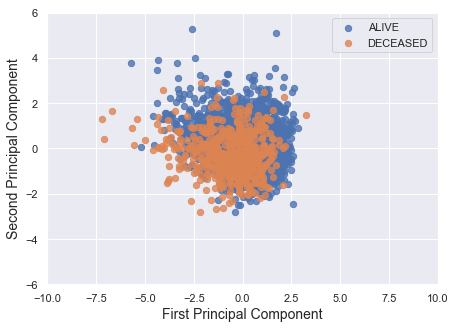

IndexError: index 2 is out of bounds for axis 1 with size 2

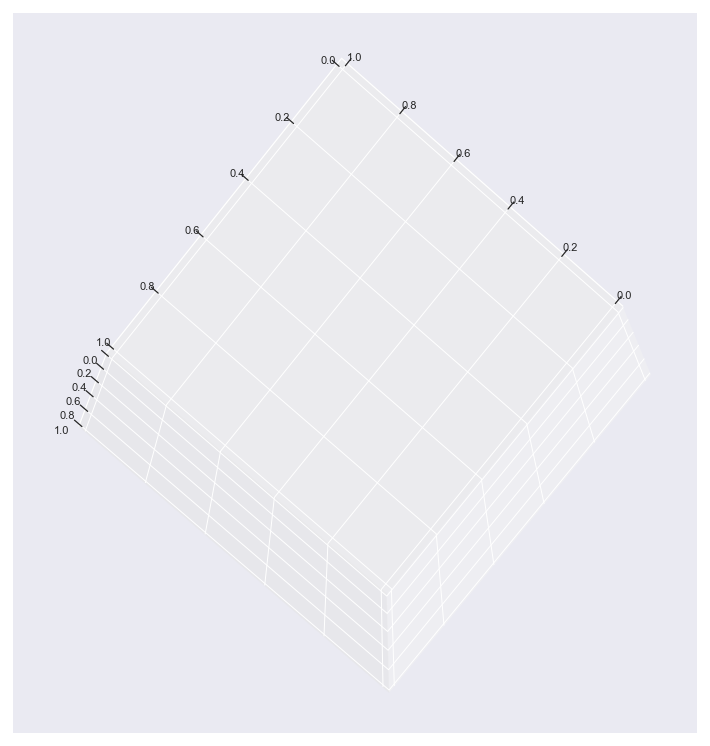

In [75]:

from mpl_toolkits.mplot3d import Axes3D

features_to_keep = []
for i in range(min(6, len(output))):
#     if i == 0 or i == 1:
#         continue
    features_to_keep.append(output[i][0])
print(features_to_keep)

print("Features size: ", len(features_to_keep))

X = df[features_to_keep].values
pca=PCA(n_components=2)
pca.fit(X)
X_pca=pca.transform(X) 

print("shape of X_pca", X_pca.shape)

ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=status
cdict={False:'red',True:'green'}
labl={False:'ALIVE',True:'DECEASED'}
marker={False:'*',True:'o'}
alpha={False:0.3, True:0.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix=np.where(labels==l)
 ax.scatter(Xax[ix],Yax[ix],s=40,label=labl[l],alpha=0.8)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.axis([-10, 10, -6, 6])
plt.legend()
plt.show()


###


fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=100, azim=130)

plt.cla()

# Reorder the labels to have colors matching the cluster results
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=status, cmap=plt.get_cmap('ocean'),
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()